In [63]:

!pip install pandas numpy lightgbm sklearn matplotlib  imblearn tqdm

import pandas as pd
from tqdm import tqdm
import warnings
import lightgbm as lgb
import numpy as np
from sklearn.model_selection import StratifiedKFold
import json
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import roc_auc_score, f1_score, precision_score, recall_score
import warnings
warnings.filterwarnings('ignore')

In [64]:
DATA_PATH = 'data/'
train = pd.read_csv(DATA_PATH + 'train_dataset.csv', sep='\t')

<AxesSubplot:title={'center':'正负样本占比'}>

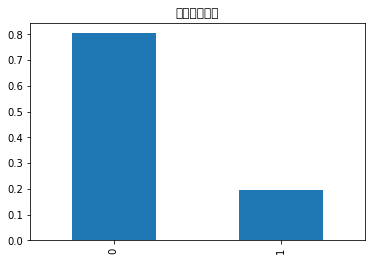

In [65]:
# 正负样本比例不均衡，4：1
train['risk_label'].value_counts(normalize=True).plot(kind='bar',title='正负样本占比')

In [66]:
# 重采样--随机采样
# https://imbalanced-learn.org/dev/over_sampling.html#random-over-sampler

ros = RandomOverSampler(random_state=0)
train, train['risk_label'] = ros.fit_resample(train, train['risk_label'])

In [67]:
train['risk_label'].value_counts(normalize=True)

0    0.5
1    0.5
Name: risk_label, dtype: float64

In [68]:
test = pd.read_csv(DATA_PATH + 'test_dataset.csv', sep='\t')
data = pd.concat([train, test])

In [69]:
data['ii'] = data['session_id'].apply(lambda x: int(x[-7:-5]))
data['location_first_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['first_lvl'])
data['location_sec_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['sec_lvl'])
data['location_third_lvl'] = data['location'].astype(str).apply(lambda x: json.loads(x)['third_lvl'])
data.drop(['client_type', 'browser_source'], axis=1, inplace=True)
data['auth_type'].fillna('1', inplace=True)

In [70]:
for col in tqdm(['user_name', 'action', 'auth_type', 'ip',
                 'ip_location_type_keyword', 'ip_risk_level', 'location', 'device_model',
                 'os_type', 'os_version', 'browser_type', 'browser_version',
                 'bus_system_code', 'op_target', 'location_first_lvl', 'location_sec_lvl',
                 'location_third_lvl']):
    lbl = LabelEncoder()
    data[col] = lbl.fit_transform(data[col])

100%|██████████| 17/17 [00:00<00:00, 40.25it/s]


In [71]:
data['op_date'] = pd.to_datetime(data['op_date'])

data['year'] = data['op_date'].dt.year
data['month'] = data['op_date'].dt.month
data['day'] = data['op_date'].dt.day
data['hour'] = data['op_date'].dt.hour

data['op_ts'] = data["op_date"].values.astype(np.int64) // 10 ** 9
data = data.sort_values(by=['user_name', 'op_ts']).reset_index(drop=True)
data['last_ts'] = data.groupby(['user_name'])['op_ts'].shift(1)
data['ts_diff1'] = data['op_ts'] - data['last_ts']

for method in ['mean', 'max', 'min', 'std', 'sum', 'median']:
    for col in ['user_name', 'ip', 'location', 'device_model', 'os_version', 'browser_version']:
        data[f'ts_diff1_{method}_' + str(col)] = data.groupby(col)['ts_diff1'].transform(method)

In [72]:
# 计算不同维度下 ts_diff1 的统计量

group_list = ['user_name','ip', 'location', 'device_model', 'os_version', 'browser_version', 'op_target']
num_feature_list = ['ts_diff1']

for group in tqdm(group_list):
    for feature in num_feature_list:
        tmp = data.groupby(group)[feature].agg([sum, min, max, np.mean]).reset_index()
        tmp = pd.merge(data, tmp, on=group, how='left')
        data['{}-mean_gb_{}'.format(feature, group)] = data[feature] - tmp['mean']
        data['{}-min_gb_{}'.format(feature, group)] = data[feature] - tmp['min']
        data['{}-max_gb_{}'.format(feature, group)] = data[feature] - tmp['max']
        data['{}/sum_gb_{}'.format(feature, group)] = data[feature] / tmp['sum']

100%|██████████| 7/7 [00:00<00:00, 22.59it/s]


In [73]:
cat_cols = ['action', 'auth_type', 'browser_type',
            'browser_version', 'bus_system_code', 'device_model',
            'ip', 'ip_location_type_keyword', 'ip_risk_level', 'location', 'op_target',
            'os_type', 'os_version', 'user_name'
            ]

In [74]:
features = [i for i in data.columns if i not in ['risk_label', 'session_id', 'op_date', 'last_ts']]

train = data[~data['risk_label'].isna()].reset_index(drop=True)
test = data[data['risk_label'].isna()].reset_index(drop=True)

In [75]:
y = train['risk_label']
KF = StratifiedKFold(n_splits=5, random_state=2020, shuffle=True)

In [76]:
params = {
    'objective': 'binary',
    'boosting_type': 'gbdt',
    'metric': 'auc',
    'n_jobs': -1,
    'learning_rate': 0.05,
    'num_leaves': 2 ** 6,
    'max_depth': 8,
    'tree_learner': 'serial',
    'colsample_bytree': 0.8,
    'subsample_freq': 1,
    'subsample': 0.8,
    'num_boost_round': 5000,
    'max_bin': 255,
    'verbose': -1,
    'seed': 2021,
    'bagging_seed': 2021,
    'feature_fraction_seed': 2021,
    'early_stopping_rounds': 100,
}


oof_lgb = np.zeros(len(train))
predictions_lgb = np.zeros((len(test)))
for fold_, (trn_idx, val_idx) in enumerate(KF.split(train.values, y.values)):
    print("fold n°{}".format(fold_))
    trn_data = lgb.Dataset(train.iloc[trn_idx][features], label=y.iloc[trn_idx])
    val_data = lgb.Dataset(train.iloc[val_idx][features], label=y.iloc[val_idx])
    num_round = 3000
    clf = lgb.train(
        params,
        trn_data,
        num_round,
        valid_sets=[trn_data, val_data],
        verbose_eval=100,
        early_stopping_rounds=50,
        categorical_feature=cat_cols
    )

    oof_lgb[val_idx] = clf.predict(train.iloc[val_idx][features], num_iteration=clf.best_iteration)
    predictions_lgb[:] += clf.predict(test[features], num_iteration=clf.best_iteration) / 5

print("AUC score: {}".format(roc_auc_score(y, oof_lgb)))
print("F1 score: {}".format(f1_score(y, [1 if i >= 0.5 else 0 for i in oof_lgb])))
print("Precision score: {}".format(precision_score(y, [1 if i >= 0.5 else 0 for i in oof_lgb])))
print("Recall score: {}".format(recall_score(y, [1 if i >= 0.5 else 0 for i in oof_lgb])))


fold n°0
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.967149	valid_1's auc: 0.877088
[200]	training's auc: 0.987568	valid_1's auc: 0.87881
Early stopping, best iteration is:
[178]	training's auc: 0.984401	valid_1's auc: 0.879486
fold n°1
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.968188	valid_1's auc: 0.89113
Early stopping, best iteration is:
[11]	training's auc: 0.933236	valid_1's auc: 0.892471
fold n°2
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.968379	valid_1's auc: 0.87977
Early stopping, best iteration is:
[52]	training's auc: 0.952877	valid_1's auc: 0.883112
fold n°3
Training until validation scores don't improve for 100 rounds
[100]	training's auc: 0.96667	valid_1's auc: 0.885439
Early stopping, best iteration is:
[2]	training's auc: 0.908157	valid_1's auc: 0.886909
fold n°4
Training until validation scores don't improve for 100 rounds
[100]	training's a

In [79]:
test['ret'] = predictions_lgb

test['id'] = range(1, 10001)
test[['id', 'ret']].to_csv('results/sub_5225.csv', index=False)
test['ret'].sum()

3467.435133409964

1.0


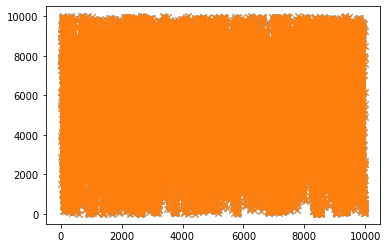

In [93]:


from matplotlib.pyplot import plot

ans = pd.read_csv('results/sub_5225.csv')
print(np.corrcoef(ans['ret'].rank().values.astype('float'), test['ret'].rank().values.astype('float'))[0, 1])
plot(ans['ret'].rank(), '-x')
plot(test['ret'].rank(), '-x')